In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# seaborn package for making pretty plots, but not necessary
try:
    import seaborn as sns
    params =   {'xtick.direction': 'in', 'ytick.direction': 'in', 'font.family': ['serif'],
                'text.usetex': True, 'text.latex.preamble': ['\usepackage{gensymb}']}
    sns.set_style("ticks", params)
except ImportError:
    print('Seaborn module is not installed.')

from IPython.display import display, Latex

In [2]:
# Enable inline plotting at lower left
%matplotlib inline
matplotlib.rcParams['image.origin'] = 'lower'

In [3]:
import multiprocessing as mp
from memory_profiler import memory_usage

In [4]:
import webbpsf
from webbpsf.webbpsf_core import poppy

poppy.conf.use_fftw = False# Doesn't play well with multiprocessing
poppy.conf.use_multiprocessing = True
poppy.conf.n_processes = int(0.75 * mp.cpu_count())
webbpsf.conf.default_output_mode = u'detector'

In [5]:
def _wrap_coeff_for_mp(args):
    """
    Internal helper routine for parallelizing computations across multiple processors.
    """
    inst,w,fov_pix,oversample = args
    hdu_list = inst.calc_psf(outfile=None, save_intermediates=False, oversample=oversample, rebin=True, \
                            fov_pixels=fov_pix, monochromatic=w*1e-6)
    return hdu_list[0].data


In [42]:
def f(fov_pix=32, os=2, pupil=None, mask=None, **kwargs):
    nc = webbpsf.NIRCam()
    nc.detector = 'B5'
    nc.filter='F430M'
    nc.pupil_mask=pupil #'WEDGELYOT'
    nc.image_mask=mask #'MASKLWB'
    nc.options['output_mode'] = 'oversampled'
    nc.options['parity'] = 'odd'
    nc.pupilopd = ('OPD_RevV_nircam_136.fits', 0)
    nc.options['source_offset_r'] = 0 #1
    nc.options['source_offset_theta'] = 0# 45
       
    hdu_list2 = nc.calc_psf(outfile=None, save_intermediates=False, oversample=os, rebin=True, \
                            fov_pixels=fov_pix, monochromatic=4.3e-6)
    del hdu_list2

In [7]:
from time import sleep

# Direct Imaging Calculations
fov_arr = np.array([16,32,128,160,256,320,512,640,1024,2048])
os_arr = np.array([1,2,4,8])
#os_arr = np.array([1,2,3,4,5,10,20,30,40,50])

mem_vals1 = np.zeros([fov_arr.size,os_arr.size])
for j,os in enumerate(os_arr):
    print(j,os)
    for i,fov_pix in enumerate(fov_arr):
        sleep(0.1)
        args = (fov_pix,os,None,None)
        mem_max = memory_usage((f,args,{}), max_usage=True, interval=0.01)
        mem_vals1[i,j] = mem_max[0]

0 1
1 2
2 4
3 8


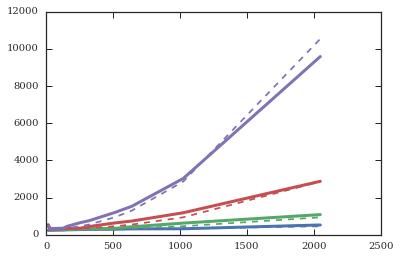

In [108]:
current_palette = sns.color_palette()
for i in range(os_arr.size):
    plt.plot(fov_arr,mem_vals1[:,i], color=current_palette[i], lw=3)
    mem_per_output = 2.5*(os_arr[i]*fov_arr)**2 * 16 / (1024**2) + 300
    plt.plot(fov_arr, mem_per_output, color=current_palette[i], ls='--')
#plt.ylim([300,1200])

In [51]:
# Coronagraphic Imaging Calculations
fov_arr = np.array([16,32,128,160,256,320,512,640,1024,2048])
os_arr = np.array([1,2,4,8])
#os_arr = np.array([1,2,3,4,5,10,20,30,40,50])

mem_vals2 = np.zeros([fov_arr.size,os_arr.size])
for j,os in enumerate(os_arr):
    print(j,os)
    for i,fov_pix in enumerate(fov_arr):
        sleep(0.1)
        args = (fov_pix,os,'WEDGELYOT','MASKLWB')
        mem_max = memory_usage((f,args,{}), max_usage=True, interval=0.01)
        mem_vals2[i,j] = mem_max[0]

0 1
1 2
2 4
3 8


(450, 12000)

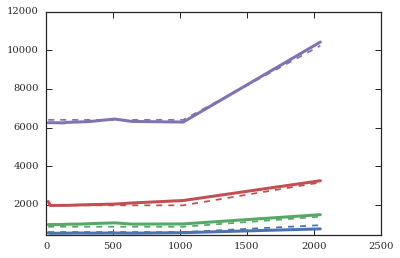

In [106]:
current_palette = sns.color_palette()
for i in range(os_arr.size):
    plt.plot(fov_arr,mem_vals2[:,i], color=current_palette[i], lw=3)
    mem_per_output = ((os_arr[i]*(fov_arr*0 + 1024*2.4))**2 * 16 / (1024**2) + 500)
    mem_per_output[fov_arr>1024] *= 1.6 
    plt.plot(fov_arr, mem_per_output, color=current_palette[i], ls='--')
plt.ylim([450,12000])